In [2]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import mdtraj
import urllib.request
import yaml
import pprint
from mpl_toolkits.mplot3d import Axes3D
#from OrderParameter import *

# SAMULI: Also this should be maybe moved to the external code that will be imported
# Download link
def download_link(doi, file):
    if "zenodo" in doi.lower():
        zenodo_entry_number = doi.split(".")[2]
        return 'https://zenodo.org/record/' + zenodo_entry_number + '/files/' + file
    else:
        print ("DOI provided: {0}".format(doi))
        print ("Repository not validated. Please upload the data for example to zenodo.org")
        return ""

Number of entries:  36
Total size of trajectories:  93.56981961429119 Gb


Text(0,0.5,'Distribution')

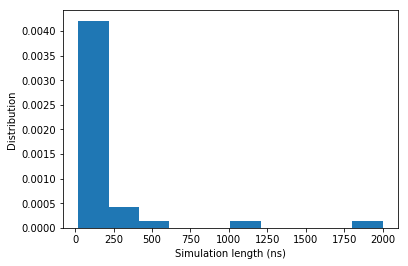

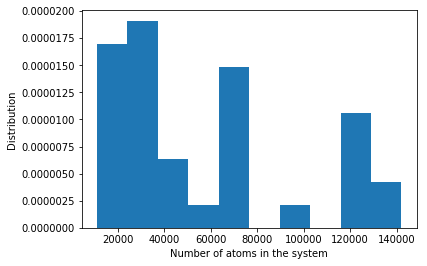

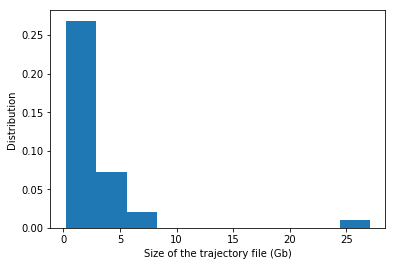

In [3]:
# Demonstration of reading the databank
# Currently lists some information on the simulations in the databank

# List of lipids that will be analyzed
lipids = {'POPC', 'POPG','POPE','POPS'} 
angles = []

# This walks through the files in the databank
# Dictionaries saved as README.yaml are read into 'readme' dictionary

count = 0
simL = []
Natoms = []
trjSIZE = []

for subdir, dirs, files in os.walk(r'../../Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.yaml"):
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
                #print(subdir)
                doi = readme.get('DOI')
                trj = readme.get('TRJ')
                tpr = readme.get('TPR')
                trj_name = subdir + '/' + readme.get('TRJ')[0][0]
                tpr_name = subdir + '/' + readme.get('TPR')[0][0]
                gro_name = subdir + '/conf.gro'
                trj_url = download_link(doi, trj[0][0])
                tpr_url = download_link(doi, tpr[0][0])
                EQtime=float(readme.get('TIMELEFTOUT'))*1000
            
                #print(readme)
                count = count + 1
                simL.append(readme.get('TRJLENGTH')*0.001)
                if readme.get('NUMBER_OF_ATOMS'):
                    Natoms.append(float(readme.get('NUMBER_OF_ATOMS')))
                trjSIZE.append(readme.get('TRAJECTORY_SIZE')/(1024*1024*1024))
                                
print("Number of entries: ",count)
print("Total size of trajectories: ",str(np.sum(trjSIZE)) + ' Gb')
distSIMl = plt.hist(simL, density=True)
plt.xlabel('Simulation length (ns)')
plt.ylabel('Distribution')
plt.figure()
distNatoms = plt.hist(Natoms, density=True)
plt.xlabel('Number of atoms in the system')
plt.ylabel('Distribution')
plt.figure()
disttrjSIZE = plt.hist(trjSIZE, density=True)
plt.xlabel('Size of the trajectory file (Gb)')
plt.ylabel('Distribution')
#print(simL)

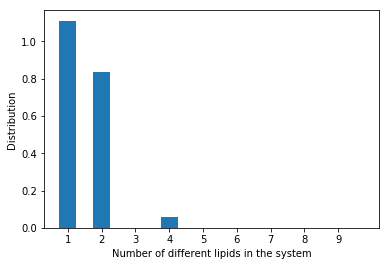

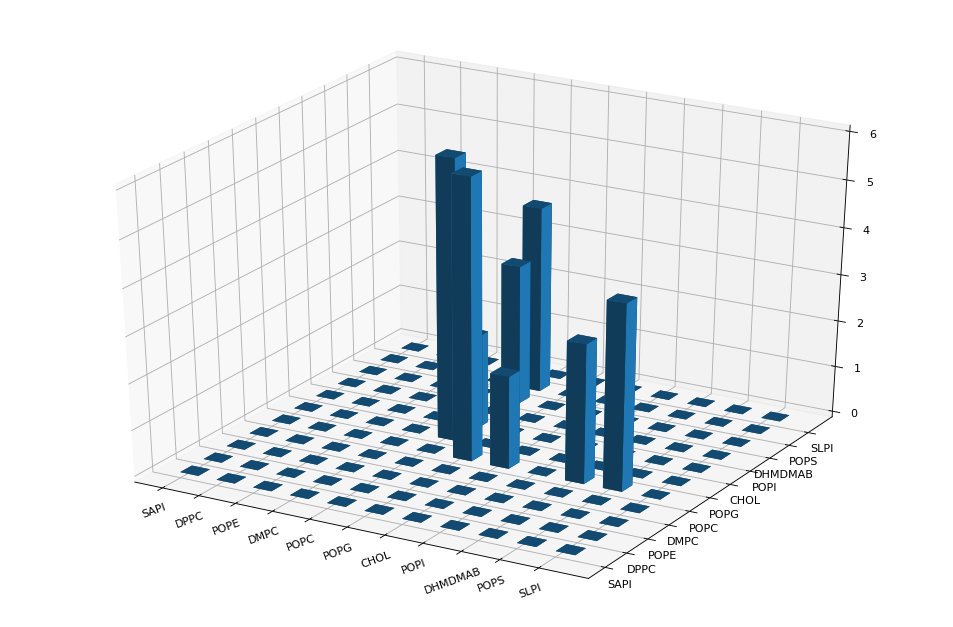

In [102]:
# Statistics on lipid compositions

lipids_dict = {
            'POPC' : {"REQUIRED": False,
                             "TYPE": "string",
                         },
            'POPG' : {"REQUIRED": False,
                            "TYPE" : "string",
                        },
            'POPS' : {"REQUIRED": False,
                            "TYPE" : "string",
                        },
            'POPE' : {"REQUIRED": False,
                            "TYPE" : "string",
                        },
            'DMPC' : {"REQUIRED": False,
                            "TYPE" : "string",
                        },
            'DPPC' : {"REQUIRED": False,
                            "TYPE" : "string",
                        },
            'POPI' : {"REQUIRED": False,
                            "TYPE" : "string",
                        },
            'SAPI' : {"REQUIRED": False,
                            "TYPE" : "string",
                        },
            'SLPI' : {"REQUIRED": False,
                            "TYPE" : "string",
                        },
            'CHOL' : {"REQUIRED": False,
                            "TYPE" : "string",
                        },
            'DHMDMAB' : {"REQUIRED": False,
                            "TYPE" : "string",
                        },
                }


molecule_numbers_dict = {
            'NPOPC' : {"REQUIRED": False,
                              "TYPE": "array",
                          },
            'NPOPG' : {"REQUIRED": False,
                            "TYPE" : "array",
                         },
            'NPOPS' : {"REQUIRED": False,
                            "TYPE" : "array",
                        },
            'NPOPE' : {"REQUIRED": False,
                       "TYPE" : "array",
                        },
            'NDMPC' : {"REQUIRED": False,
                       "TYPE" : "array",
                        },
            'NDPPC' : {"REQUIRED": False,
                       "TYPE" : "array",
                        },
            'NPOPI' : {"REQUIRED": False,
                       "TYPE" : "array",
                        },
            'NSAPI' : {"REQUIRED": False,
                       "TYPE" : "array",
                        },
            'NSLPI' : {"REQUIRED": False,
                       "TYPE" : "array",
                        },
    
            'NCHOL' : {"REQUIRED": False,
                       "TYPE" : "array",
                     },
            'NDHMDMAB' : {"REQUIRED": False,
                            "TYPE" : "array",
                        },
    
            'NPOT' : {"REQUIRED": False,
                            "TYPE" : "integer",
                        },
            'NSOD' : {"REQUIRED": False,
                            "TYPE" : "integer",
                        },
            'NCLA' : {"REQUIRED": False,
                            "TYPE" : "integer",
                        },
            'NCAL' : {"REQUIRED": False,
                             "TYPE" : "integer",
                         },
            'NSOL' : {"REQIRED": False,
                            "TYPE" : "integer",
                        },
    
                }

Nmixture_dict = {}
for lipid1 in lipids_dict:
    tmpDICT = {}
    for lipid2 in lipids_dict:
        tmpDICT[lipid2] = 0
    Nmixture_dict[lipid1] = tmpDICT

count = 0
simL = []
Natoms = []
trjSIZE = []
Ncomponents = []

for subdir, dirs, files in os.walk(r'../../Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.yaml"):
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
                #print(subdir)
                doi = readme.get('DOI')
                trj = readme.get('TRJ')
                tpr = readme.get('TPR')
                trj_name = subdir + '/' + readme.get('TRJ')[0][0]
                tpr_name = subdir + '/' + readme.get('TPR')[0][0]
                gro_name = subdir + '/conf.gro'
                trj_url = download_link(doi, trj[0][0])
                tpr_url = download_link(doi, tpr[0][0])
                EQtime=float(readme.get('TIMELEFTOUT'))*1000
            
                count = 0
                lipidlist = []
                for lipid in lipids_dict:
                    #print(lipid)
                    if(np.sum(readme.get('N' + lipid))):
                        if(np.sum(readme.get('N' + lipid)) > 0):
                            count = count +1
                            lipidlist.append(lipid)
                Ncomponents.append(count)
                if(count == 2):
                    #print(lipidlist)
                    for lipid1 in lipids_dict:
                        for lipid2 in lipids_dict:
                            if(np.sum(readme.get('N' + lipid1)) and np.sum(readme.get('N' + lipid2))):
                                if(not lipid1==lipid2 and np.sum(readme.get('N' + lipid1)) > 0 and np.sum(readme.get('N' + lipid2)) > 0):
                                        Nmixture_dict[lipid1][lipid2] += 1
                                        #print(Nmixture_dict[lipid1][lipid2])
                
                #count = count + 1
                #simL.append(readme.get('TRJLENGTH')*0.001)
                #if readme.get('NUMBER_OF_ATOMS'):
                #    Natoms.append(float(readme.get('NUMBER_OF_ATOMS')))
                #trjSIZE.append(readme.get('TRAJECTORY_SIZE')/(1024*1024*1024))
                                
distNcomponents = plt.hist(Ncomponents, bins=np.arange(0.75,10,0.5), density=True)
plt.xlabel('Number of different lipids in the system')
plt.ylabel('Distribution')
plt.xticks(range(1,10))
plt.figure()


fig = plt.figure(figsize=(15, 10), dpi=80)
ax1 = fig.add_subplot(111, projection='3d')

count1 = 0
x = []
y = []
z = []
xlabels = []
for lipid1 in lipids_dict:
    count2 = 0
    xlabels.append(lipid1)
    for lipid2 in lipids_dict:
        x.append(count1)
        y.append(count2)
        z.append(Nmixture_dict[lipid1][lipid2])
        count2 += 1
    count1 += 1
#_xx, _yy = np.meshgrid(range(len(lipids_dict.keys())), range(len(lipids_dict.keys())))
#x, y = _xx.ravel(), _yy.ravel()

xlabels = np.array(xlabels)
ax1.w_xaxis.set_ticklabels(xlabels,rotation=20)
ax1.w_yaxis.set_ticklabels(xlabels)
ax1.set_xticks(range(len(xlabels)))
ax1.set_yticks(range(len(xlabels)))

x = np.array(x)
y = np.array(y)
z = np.array(z)
bottom = np.zeros_like(x)
ax1.bar3d(x, y, bottom,0.5,0.5,z)